# Model training

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Global Configurations
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3  
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']

# Dataset Preparation
def extract_frames(video_path, output_size=IMAGE_SIZE):
    """Extract frames from a video and resize them."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_data(video_paths, labels, frame_count=FRAME_COUNT):
    """Preprocess videos into fixed frame count sequences."""
    X, y = [], []
    for i, video_path in enumerate(video_paths):
        frames = extract_frames(video_path)
        if len(frames) >= frame_count:
            X.append(frames[:frame_count])
            y.append(labels[i])
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# CNN Model for Spatial Feature Extraction
def build_cnn():
    """Build a CNN model for spatial feature extraction."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# RNN Model for Temporal Analysis
def build_rnn(input_shape, num_classes):
    """Build an RNN for temporal feature analysis."""
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Combined Spatio-Temporal Model
def build_spatio_temporal_model(cnn, rnn, frame_count, num_classes):
    """Combine CNN and RNN for spatio-temporal analysis."""
    video_input = Input(shape=(frame_count, 224, 224, 3))
    cnn_output = TimeDistributed(cnn)(video_input)
    ##print cnn_output
    rnn_output = rnn(cnn_output)
    ##print rnn o/p
    model = Model(inputs=video_input, outputs=rnn_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example Dataset
video_paths = ['Downloads/dataset/Burglary/Burglary009_x264.mp4',
               'Downloads/dataset/Burglary/Burglary059_x264.mp4', 
               'Downloads/dataset/Burglary/Burglary098_x264.mp4',
               'Downloads/dataset/Abuse/Abuse016_x264.mp4',
               'Downloads/dataset/Abuse/Abuse018_x264.mp4',
               'Downloads/dataset/Abuse/Abuse019_x264.mp4',
               'Downloads/dataset/Abuse/Abuse041_x264.mp4',
               'Downloads/dataset/Arrest/Arrest015_x264.mp4',
               'Downloads/dataset/Arrest/Arrest011_x264.mp4',
              'Downloads/dataset/Arrest/Arrest042_x264.mp4'
              ]  
labels = [0, 0, 0, 1, 1, 1, 1, 2, 2, 2]  

# Preprocess Data
X, y = preprocess_data(video_paths, labels, frame_count=FRAME_COUNT)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Models
cnn = build_cnn()
rnn = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)
model = build_spatio_temporal_model(cnn, rnn, FRAME_COUNT, NUM_CLASSES)

# Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

# Save the Model
model.save('activity_recognition_model.keras')

# Real-Time Detection
def predict_activity(model, video_path):
    """Predict the activity in a video."""
    frames = extract_frames(video_path)
    frames = frames[:FRAME_COUNT]
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)
    return np.argmax(prediction)

# Test Prediction
test_video = 'Downloads/dataset/Arrest/Arrest042_x264.mp4'
result = predict_activity(model, test_video)
print(f"Predicted activity: {CLASS_NAMES[result]}")


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 211s 211s/step - accuracy: 0.2500 - loss: 1.1915 - val_accuracy: 0.0000e+00 - val_loss: 1.2184
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 143s 143s/step - accuracy: 0.8750 - loss: 0.6989 - val_accuracy: 0.0000e+00 - val_loss: 1.2698
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 126s 126s/step - accuracy: 1.0000 - loss: 0.3766 - val_accuracy: 0.0000e+00 - val_loss: 1.5217
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 132s 132s/step - accuracy: 1.0000 - loss: 0.1900 - val_accuracy: 0.0000e+00 - val_loss: 1.9230
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 138s 138s/step - accuracy: 1.0000 - loss: 0.1049 - val_accuracy: 0.0000e+00 - val_loss: 2.2826
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted activity: Arrest


In [3]:
pip install flask


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 1.3 MB/s eta 0:00:00a 0:00:01
  Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
You should consider upgrading via the '/Users/arjungoyal/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import cv2
import numpy as np
import threading
import logging
from collections import deque
from datetime import datetime
from flask import Flask, render_template_string
from PyQt5.QtWidgets import QApplication, QLabel, QPushButton, QWidget, QVBoxLayout
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtCore import QTimer
from tensorflow.keras.models import load_model
import smtplib
from email.mime.text import MIMEText

# --------- Logging Setup ----------
logging.basicConfig(filename="alerts.log", level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# --------- Alert System ----------
def send_email_alert(subject, body):
    try:
        sender = "youremail@example.com"
        receiver = "receiver@example.com"
        password = "your_app_password"

        msg = MIMEText(body)
        msg['Subject'] = subject
        msg['From'] = sender
        msg['To'] = receiver

        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
            server.login(sender, password)
            server.send_message(msg)
        logging.info("Email alert sent.")
    except Exception as e:
        logging.error(f"Failed to send alert email: {e}")


# --------- Preprocessing Function ----------
def preprocess_frame(frame, target_size=(224, 224)):
    frame_resized = cv2.resize(frame, target_size)
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    frame_normalized = frame_rgb.astype("float32") / 255.0
    return frame_normalized


# --------- Real-Time Activity Detector ----------
class RealTimeActivityDetector:
    def __init__(self, model_path, sequence_length=30):
        self.model = load_model(model_path)
        self.sequence_length = sequence_length
        self.frame_buffer = deque(maxlen=sequence_length)
        self.labels = ['burglary', 'abuse', 'arrest']  # update with your model's classes

    def predict(self, frame):
        preprocessed = preprocess_frame(frame)
        self.frame_buffer.append(preprocessed)

        if len(self.frame_buffer) == self.sequence_length:
            sequence = np.expand_dims(np.array(self.frame_buffer), axis=0)
            predictions = self.model.predict(sequence, verbose=0)[0]
            label_idx = np.argmax(predictions)
            confidence = predictions[label_idx]
            return self.labels[label_idx], confidence
        return None, None


# --------- PyQt GUI ----------
class SurveillanceApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Real-Time Activity Detection")
        self.setGeometry(100, 100, 800, 600)

        self.video_label = QLabel("Video Feed")
        self.start_btn = QPushButton("Start Detection")
        self.stop_btn = QPushButton("Stop Detection")

        layout = QVBoxLayout()
        layout.addWidget(self.video_label)
        layout.addWidget(self.start_btn)
        layout.addWidget(self.stop_btn)
        self.setLayout(layout)

        self.cap = None
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_frame)
        self.detector = RealTimeActivityDetector("activity_recognition_model.keras")
        self.last_alert_time = datetime.min

        self.start_btn.clicked.connect(self.start_camera)
        self.stop_btn.clicked.connect(self.stop_camera)

    def start_camera(self):
        self.cap = cv2.VideoCapture(0)
        self.timer.start(30)  # roughly 30 FPS

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return

        label, confidence = self.detector.predict(frame)
        if label and confidence > 0.8:
            cv2.putText(frame, f"{label.upper()} ({confidence*100:.1f}%)", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            # Alert every 10 sec max
            if (datetime.now() - self.last_alert_time).seconds > 10:
                logging.info(f"Alert: {label} detected with confidence {confidence:.2f}")
                send_email_alert("ALERT: Suspicious Activity", f"{label} detected with {confidence*100:.2f}% confidence")
                self.last_alert_time = datetime.now()
        else:
            cv2.putText(frame, "Normal", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, ch = rgb_frame.shape
        qt_image = QImage(rgb_frame.data, w, h * ch, QImage.Format_RGB888)
        self.video_label.setPixmap(QPixmap.fromImage(qt_image))

    def stop_camera(self):
        self.timer.stop()
        if self.cap:
            self.cap.release()
        self.video_label.clear()


# --------- Flask App for LAN Access ----------
flask_app = Flask(__name__)

@flask_app.route('/')
def index():
    return render_template_string("<h2>Real-Time Activity Detection Running</h2>")


def run_flask():
    try:
        flask_app.run(host='0.0.0.0', port=5050)  # safer default port
    except Exception as e:
        logging.error(f"Flask server error: {e}")


# --------- Main Entry ----------
if __name__ == "__main__":
    flask_thread = threading.Thread(target=run_flask, daemon=True)
    flask_thread.start()

    qt_app = QApplication(sys.argv)
    window = SurveillanceApp()
    window.show()
    sys.exit(qt_app.exec_())


 * Serving Flask app '__main__'
 * Debug mode: off


SystemExit: 0

/Users/arjungoyal/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# output shape

In [7]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import TimeDistributed, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# Constants
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']
NUM_CLASSES = len(CLASS_NAMES)

# --- Load and Build Components Again (Same Architecture Required) ---

# Load trained full model
full_model = load_model('activity_recognition_model.keras')

# Rebuild CNN
def build_cnn():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

cnn_model = build_cnn()

# Rebuild RNN
def build_rnn(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

rnn_model = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)

# --- Frame Extraction ---
def extract_frames(video_path, output_size=(224, 224), frame_count=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
        if len(frames) == frame_count:
            break
    cap.release()
    return np.array(frames)

# --- Load test video ---
video_path = 'Downloads/dataset/Burglary/Burglary059_x264.mp4'
frames = extract_frames(video_path)
frames = frames[:FRAME_COUNT]
frames_batch = np.expand_dims(frames, axis=0)  # (1, 30, 224, 224, 3)

# --- Get CNN Output ---
cnn_features = np.array([cnn_model.predict(frames_batch[0])])  # shape: (30, 2048)
print(f"\n✅ CNN Output shape: {cnn_features.shape} (frame_count x feature_vector_size)")
print("CNN Output Vector (1st frame):\n", cnn_features[0][0])

# --- Get RNN Output ---
rnn_input = np.expand_dims(cnn_features[0], axis=0)  # (1, 30, 2048)
rnn_output = rnn_model.predict(rnn_input)
print(f"\n✅ RNN Output shape: {rnn_output.shape} (1 x num_classes)")
print("RNN Output Vector:\n", rnn_output)

# --- Final Model Prediction ---
prediction = full_model.predict(frames_batch)
predicted_class = np.argmax(prediction)
print(f"\n🎯 Final Model Prediction: {CLASS_NAMES[predicted_class]}")
print("Final Model Output Vector:\n", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

✅ CNN Output shape: (1, 30, 2048) (frame_count x feature_vector_size)
CNN Output Vector (1st frame):
 [0.00599981 2.078606   0.45295173 ... 1.1780607  0.24603099 0.9764378 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

✅ RNN Output shape: (1, 3) (1 x num_classes)
RNN Output Vector:
 [[0.27041426 0.38492414 0.34466153]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

🎯 Final Model Prediction: Burglary
Final Model Output Vector:
 [[0.8912993  0.08720166 0.02149893]]


# CNN & RNN outputs CSV files 

In [3]:
import os
import cv2
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

# Constants
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']
NUM_CLASSES = len(CLASS_NAMES)

# Paths
VIDEO_DIR = 'Downloads/dataset'  # Root dataset directory
OUTPUT_CSV = 'activity_predictions_log.csv'

# Load trained full model
full_model = load_model('activity_recognition_model.keras')

# Rebuild CNN
def build_cnn():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

cnn_model = build_cnn()

# Rebuild RNN
def build_rnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

rnn_model = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)

# Extract frames from video
def extract_frames(video_path, output_size=(224, 224), frame_count=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
        if len(frames) == frame_count:
            break
    cap.release()
    if len(frames) < frame_count:
        print(f"⚠️ Skipping {video_path}: Not enough frames ({len(frames)})")
        return None
    return np.array(frames)

# Walk through videos and make predictions
def process_videos_and_log(video_dir, output_csv):
    results = []

    for root, _, files in os.walk(video_dir):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(root, file)
                print(f"\n📹 Processing: {video_path}")
                
                frames = extract_frames(video_path)
                if frames is None:
                    continue
                
                frames_batch = np.expand_dims(frames, axis=0)  # (1, 30, 224, 224, 3)

                # CNN Output
                cnn_features = np.array([cnn_model.predict(frames_batch[0], verbose=0)])  # (1, 30, 2048)
                
                # RNN Output
                rnn_input = np.expand_dims(cnn_features[0], axis=0)  # (1, 30, 2048)
                rnn_output = rnn_model.predict(rnn_input, verbose=0)  # (1, num_classes)

                # Final Model Output
                final_output = full_model.predict(frames_batch, verbose=0)
                predicted_class = np.argmax(final_output)

                # Save record
                results.append({
                    "Video Name": file,
                    "Predicted Class": CLASS_NAMES[predicted_class],
                    "CNN Vector (1st Frame)": cnn_features[0][0][:5].tolist(),  # First 5 values for brevity
                    "RNN Output": rnn_output[0].tolist(),
                    "Final Output": final_output[0].tolist()
                })

    # Write to CSV
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        for row in results:
            writer.writerow(row)

    print(f"\n✅ All predictions logged to: {output_csv}")

# Run it
process_videos_and_log(VIDEO_DIR, OUTPUT_CSV)



📹 Processing: Downloads/dataset/Burglary/Burglary089_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary010_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary083_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary059_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary098_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary062_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary009_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting036_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting037_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting030_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting005_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting013_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting048_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting022_x264.mp4

📹 Processing: Downloads/dataset/Arrest/Arrest015_x264.mp4

📹 Processing: Downloads/dataset/Arrest/Arrest030_x264.mp4


In [1]:
import os
import cv2
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

# Constants
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']
NUM_CLASSES = len(CLASS_NAMES)

# Paths
VIDEO_DIR = 'Downloads/dataset'  # Root dataset directory
OUTPUT_CSV = 'activity_predictions_log_detailed1.csv'

# Load trained full model
full_model = load_model('activity_recognition_model.keras')

# Rebuild CNN
def build_cnn():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

cnn_model = build_cnn()

# Rebuild RNN
def build_rnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

rnn_model = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)

# Extract frames from video
def extract_frames(video_path, output_size=(224, 224), frame_count=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
        if len(frames) == frame_count:
            break
    cap.release()
    if len(frames) < frame_count:
        print(f"⚠️ Skipping {video_path}: Not enough frames ({len(frames)})")
        return None
    return np.array(frames)

# Walk through videos and make predictions
def process_videos_and_log(video_dir, output_csv):
    results = []

    for root, _, files in os.walk(video_dir):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(root, file)
                print(f"\n📹 Processing: {video_path}")
                
                frames = extract_frames(video_path)
                if frames is None:
                    continue
                
                frames_batch = np.expand_dims(frames, axis=0)  # (1, 30, 224, 224, 3)

                # CNN Output
                cnn_features = np.array([cnn_model.predict(frames_batch[0], verbose=0)])  # (1, 30, 2048)

                # RNN Output
                rnn_input = np.expand_dims(cnn_features[0], axis=0)  # (1, 30, 2048)
                rnn_output = rnn_model.predict(rnn_input, verbose=0)  # (1, num_classes)

                # Final Model Output
                final_output = full_model.predict(frames_batch, verbose=0)
                predicted_class = np.argmax(final_output)

                # Prepare 5 CNN vectors for CSV (reduce size for readability)
                cnn_vectors = cnn_features[0][:5]  # shape: (5, 2048)
                cnn_vectors_flat = []
                for i in range(5):
                    # Add first 10 features from each frame for brevity
                    cnn_vectors_flat.extend(cnn_vectors[i][:10].tolist())

                results.append({
                    "Video Name": file,
                    "Predicted Class": CLASS_NAMES[predicted_class],
                    "RNN Output": rnn_output[0].tolist(),
                    "Final Output": final_output[0].tolist(),
                    "CNN_Frame1-5_First10Vals": cnn_vectors_flat
                })

    # Prepare headers dynamically
    cnn_headers = [f"F{f+1}_CNN_feat_{i+1}" for f in range(5) for i in range(10)]
    headers = ["Video Name", "Predicted Class", "RNN Output", "Final Output"] + cnn_headers

    # Write to CSV
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for row in results:
            flat_row = {
                "Video Name": row["Video Name"],
                "Predicted Class": row["Predicted Class"],
                "RNN Output": str(row["RNN Output"]),
                "Final Output": str(row["Final Output"]),
            }
            for i, val in enumerate(row["CNN_Frame1-5_First10Vals"]):
                flat_row[cnn_headers[i]] = val
            writer.writerow(flat_row)

    print(f"\n✅ All predictions logged with CNN data from 5 frames → {output_csv}")

# Run it
process_videos_and_log(VIDEO_DIR, OUTPUT_CSV)



📹 Processing: Downloads/dataset/Burglary/Burglary089_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary010_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary083_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary059_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary098_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary062_x264.mp4

📹 Processing: Downloads/dataset/Burglary/Burglary009_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting036_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting037_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting030_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting005_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting013_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting048_x264.mp4

📹 Processing: Downloads/dataset/Fighting/Fighting022_x264.mp4

📹 Processing: Downloads/dataset/Arrest/Arrest015_x264.mp4

📹 Processing: Downloads/dataset/Arrest/Arrest030_x264.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


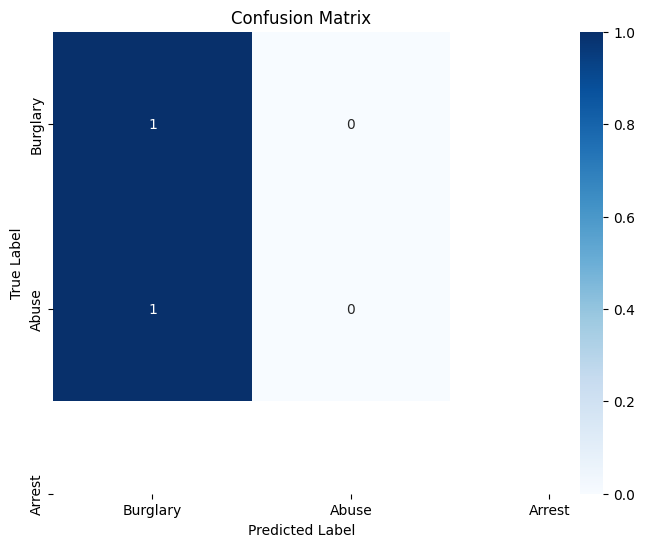

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the trained model (if not already defined)
model = load_model('activity_recognition_model.keras')  # Ensure model is saved properly

# Define class names
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']

def plot_confusion_matrix(model, X_test, y_test, class_names):
    """Plot the confusion matrix."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class indices
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, X_test, y_test, CLASS_NAMES)


In [4]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 2048)       │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 3)              │     2,574,339 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,379,915 (299.00 MB)

 Trainable params: 26,108,931 (99.60 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 52,217,864 (199.20 MB)

# Video classification using ResNet50

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Global Configurations
FRAME_COUNT=30
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3  

# Dataset Preparation
def extract_frames(video_path, output_size=IMAGE_SIZE):
    """Extract frames from a video and resize them."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_data(video_paths, labels, start_frame=200, end_frame=230):
    """Preprocess videos into fixed frame count sequences from a specified range."""
    X, y = [], []
    for i, video_path in enumerate(video_paths):
        frames = extract_frames(video_path)
        if len(frames) > end_frame:  # Ensure there are enough frames
            X.append(frames[start_frame:end_frame])  # Take frames from start_frame to end_frame
            y.append(labels[i])
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)


# CNN Model for Spatial Feature Extraction
def build_cnn():
    """Build a CNN model for spatial feature extraction."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Combined Spatio-Temporal Model without RNN
def build_spatio_temporal_model(cnn, frame_count, num_classes):
    """Combine CNN for spatio-temporal analysis."""
    video_input = Input(shape=(frame_count, 224, 224, 3))
    cnn_output = TimeDistributed(cnn)(video_input)
    
    # Flatten the output and add Dense layers for classification
    x = tf.keras.layers.Flatten()(cnn_output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example Dataset
video_paths = ['Downloads/dataset/Burglary/Burglary059_x264.mp4',
               'Downloads/dataset/Burglary/Burglary009_x264.mp4',
               'Downloads/dataset/Burglary/Burglary062_x264.mp4', 
               'Downloads/dataset/Burglary/Burglary083_x264.mp4',
               'Downloads/dataset/Burglary/Burglary089_x264.mp4',
               'Downloads/dataset/Abuse/Abuse016_x264.mp4',
               'Downloads/dataset/Abuse/Abuse018_x264.mp4',
               'Downloads/dataset/Abuse/Abuse022_x264.mp4',
               'Downloads/dataset/Abuse/Abuse032_x264.mp4',
               'Downloads/dataset/Abuse/Abuse041_x264.mp4',
               'Downloads/dataset/Abuse/Abuse044_x264.mp4',
               'Downloads/dataset/Arrest/Arrest030_x264.mp4',
               'Downloads/dataset/Arrest/Arrest033_x264.mp4',
              'Downloads/dataset/Arrest/Arrest015_x264.mp4',
              'Downloads/dataset/Arrest/Arrest011_x264.mp4']  # Replace with actual paths

labels = [0, 0, 0,0, 0, 1,1,1, 1, 1, 1, 2, 2,2,2]  # Example: burglary (0), abuse (1), arrest (2)

# Preprocess Data
X, y = preprocess_data(video_paths, labels, start_frame=200, end_frame=230)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Models
cnn = build_cnn()
model = build_spatio_temporal_model(cnn, FRAME_COUNT, NUM_CLASSES)

# Train the Model
model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

# Save the Model
model.save('activity_recognition_model1.keras')

# Real-Time Detection
def predict_activity(model, video_path):
    """Predict the activity in a video."""
    frames = extract_frames(video_path)
    frames = frames[:FRAME_COUNT]
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)
    return np.argmax(prediction)

# Test Prediction
test_video = 'Downloads/dataset/Burglary/Burglary059_x264.mp4'  # Replace with the path to your test video
result = predict_activity(model, test_video)
activity_labels = ['Burglary', 'Abuse', 'Arrest']
print(f"Predicted activity: {activity_labels[result]}")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 326s 47s/step - accuracy: 0.2500 - loss: 16.6396 - val_accuracy: 0.3333 - val_loss: 63.8408
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 145s 30s/step - accuracy: 0.3889 - loss: 34.4294 - val_accuracy: 0.0000e+00 - val_loss: 18.0607
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 134s 36s/step - accuracy: 0.6944 - loss: 8.2382 - val_accuracy: 0.3333 - val_loss: 41.2258
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 122s 35s/step - accuracy: 0.5556 - loss: 13.5898 - val_accuracy: 0.3333 - val_loss: 33.0536
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 114s 36s/step - accuracy: 0.7917 - loss: 2.5563 - val_accuracy: 0.3333 - val_loss: 59.9799
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Predicted activity: Burglary


In [6]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 2048)       │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,864,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,251,403 (359.54 MB)

 Trainable params: 31,399,427 (119.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 62,798,856 (239.56 MB)

In [7]:
import tensorflow as tf

# Load the trained model
model_path = "activity_recognition_model1.keras"  
model = tf.keras.models.load_model(model_path)

# Test video path
test_video = "Downloads/dataset/Abuse/Abuse016_x264.mp4" 

# Predict activity using the trained model
result = predict_activity(model, test_video)
# Evaluate the Model on Test Data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the Accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
# Activity labels
activity_labels = ['Burglary', 'Abuse', 'Arrest']
print(f"Predicted activity: {activity_labels[result]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.3333 - loss: 59.9799
Test Accuracy: 33.33%
Predicted activity: Abuse


# Video classification using VGG16

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, TimeDistributed, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Global Configurations
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3  

# Dataset Preparation
def extract_frames(video_path, output_size=IMAGE_SIZE):
    """Extract frames from a video and resize them."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_data(video_paths, labels, start_frame=150, end_frame=180):
    """Preprocess videos into fixed frame count sequences from a specified range."""
    X, y = [], []
    for i, video_path in enumerate(video_paths):
        frames = extract_frames(video_path)
        if len(frames) > end_frame:  # Ensure there are enough frames
            X.append(frames[start_frame:end_frame])  # Take frames from start_frame to end_frame
            y.append(labels[i])
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# CNN Model for Spatial Feature Extraction
def build_cnn():
    """Build a CNN model for spatial feature extraction using VGG16."""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Combined Spatio-Temporal Model without RNN
def build_spatio_temporal_model(cnn, frame_count, num_classes):
    """Combine CNN for spatio-temporal analysis."""
    video_input = Input(shape=(frame_count, 224, 224, 3))
    cnn_output = TimeDistributed(cnn)(video_input)
    
    # Flatten the output and add Dense layers for classification
    x = Flatten()(cnn_output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example Dataset
video_paths = ['Downloads/dataset/Burglary/Burglary059_x264.mp4',
               'Downloads/dataset/Burglary/Burglary009_x264.mp4',
               'Downloads/dataset/Burglary/Burglary062_x264.mp4', 
               'Downloads/dataset/Burglary/Burglary083_x264.mp4',
               'Downloads/dataset/Burglary/Burglary089_x264.mp4',
               'Downloads/dataset/Abuse/Abuse016_x264.mp4',
               'Downloads/dataset/Abuse/Abuse018_x264.mp4',
               'Downloads/dataset/Abuse/Abuse022_x264.mp4',
               'Downloads/dataset/Abuse/Abuse032_x264.mp4',
               'Downloads/dataset/Abuse/Abuse041_x264.mp4',
               'Downloads/dataset/Abuse/Abuse044_x264.mp4',
               'Downloads/dataset/Arrest/Arrest030_x264.mp4',
               'Downloads/dataset/Arrest/Arrest033_x264.mp4',
               'Downloads/dataset/Arrest/Arrest015_x264.mp4',
               'Downloads/dataset/Arrest/Arrest011_x264.mp4']  # Replace with actual paths

labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]  # Example: burglary (0), abuse (1), arrest (2)

# Preprocess Data
X, y = preprocess_data(video_paths, labels, start_frame=150, end_frame=180)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Models
cnn = build_cnn()
model = build_spatio_temporal_model(cnn, FRAME_COUNT, NUM_CLASSES)

# Train the Model
model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

# Save the Model
model.save('activity_recognition_model_vgg16.keras')

# Real-Time Detection
def predict_activity(model, video_path):
    """Predict the activity in a video."""
    frames = extract_frames(video_path)
    frames = frames[:FRAME_COUNT]
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)
    return np.argmax(prediction)

# Test Prediction
test_video = 'Downloads/dataset/Burglary/Burglary059_x264.mp4'  # Replace with the path to your test video
result = predict_activity(model, test_video)
activity_labels = ['Burglary', 'Abuse', 'Arrest']
print(f"Predicted activity: {activity_labels[result]}")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 140s 50s/step - accuracy: 0.2917 - loss: 63.7929 - val_accuracy: 0.3333 - val_loss: 82.7560
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 180s 60s/step - accuracy: 0.2500 - loss: 58.0696 - val_accuracy: 0.3333 - val_loss: 13.3908
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 154s 54s/step - accuracy: 0.2083 - loss: 45.7541 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 155s 56s/step - accuracy: 0.4028 - loss: 1.2288 - val_accuracy: 0.3333 - val_loss: 1.1029
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 152s 55s/step - accuracy: 0.4861 - loss: 2.5527 - val_accuracy: 0.3333 - val_loss: 1.3305
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted activity: Burglary


In [15]:
import tensorflow as tf

# Load the trained model
model_path = "activity_recognition_model_vgg16.keras"  
model = tf.keras.models.load_model(model_path)

# Test video path
test_video = "Downloads/dataset/Burglary/Burglary059_x264.mp4" 

# Predict activity using the trained model
result = predict_activity(model, test_video)
# Evaluate the Model on Test Data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the Accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
# Activity labels
activity_labels = ['Burglary', 'Abuse', 'Arrest']
print(f"Predicted activity: {activity_labels[result]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3333 - loss: 1.3305
Test Accuracy: 33.33%
Predicted activity: Burglary


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 366s 366s/step - accuracy: 1.0000 - loss: 1.0195 - val_accuracy: 1.0000 - val_loss: 0.4508
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 1.0000 - loss: 0.4450 - val_accuracy: 1.0000 - val_loss: 0.2578
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 1.0000 - loss: 0.2564 - val_accuracy: 1.0000 - val_loss: 0.1467
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 1.0000 - loss: 0.1456 - val_accuracy: 1.0000 - val_loss: 0.0863
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 1.0000 - loss: 0.0865 - val_accuracy: 1.0000 - val_loss: 0.0521
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


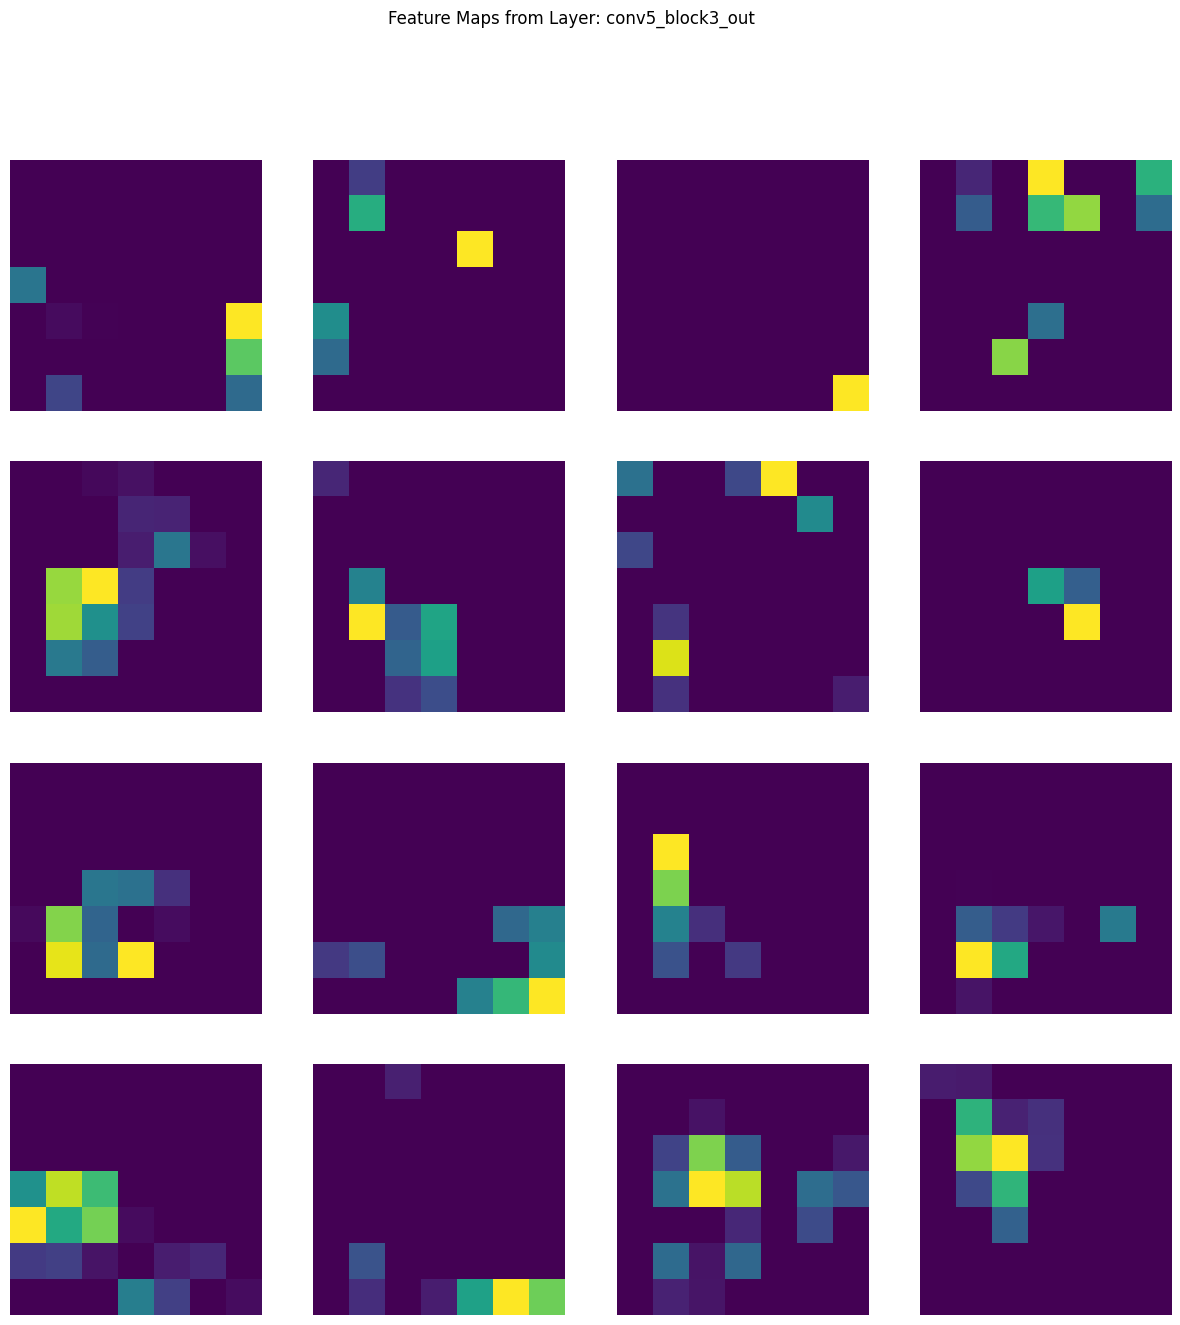

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m15512841536\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 30, 2048), dtype=float32)\n  • training=False\n  • mask=None'

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Global Configurations
FRAME_COUNT = 30
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3  
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']

# Dataset Preparation
def extract_frames(video_path, output_size=IMAGE_SIZE):
    """Extract frames from a video and resize them."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_data(video_paths, labels, frame_count=FRAME_COUNT):
    """Preprocess videos into fixed frame count sequences."""
    X, y = [], []
    for i, video_path in enumerate(video_paths):
        frames = extract_frames(video_path)
        if len(frames) >= frame_count:
            X.append(frames[:frame_count])
            y.append(labels[i])
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# CNN Model for Spatial Feature Extraction
def build_cnn():
    """Build a CNN model for spatial feature extraction."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# RNN Model for Temporal Analysis
def build_rnn(input_shape, num_classes):
    """Build an RNN for temporal feature analysis."""
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  
        LSTM(256, return_sequences=True, name='lstm_1'),
        LSTM(128, return_sequences=True, name='lstm_2'),
        LSTM(64, return_sequences=False, name='lstm_3'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Combined Spatio-Temporal Model
def build_spatio_temporal_model(cnn, rnn, frame_count, num_classes):
    """Combine CNN and RNN for spatio-temporal analysis."""
    video_input = Input(shape=(frame_count, 224, 224, 3))
    cnn_output = TimeDistributed(cnn)(video_input)
    rnn_output = rnn(cnn_output)
    model = Model(inputs=video_input, outputs=rnn_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Feature Map Visualization for CNN
def visualize_feature_maps(cnn_model, video_path, layer_name='conv5_block3_out'):
    """Visualize feature maps from a specific CNN layer."""
    frames = extract_frames(video_path)[:FRAME_COUNT]
    frames = np.expand_dims(frames[0], axis=0)  # Select the first frame
    
    intermediate_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(layer_name).output)
    feature_maps = intermediate_model.predict(frames)
    
    num_features = feature_maps.shape[-1]  # Number of filters
    plt.figure(figsize=(15, 15))
    for i in range(min(num_features, 16)):  # Display first 16 feature maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from Layer: {layer_name}")
    plt.show()

# RNN Hidden State Evolution
def visualize_rnn_hidden_states(rnn_model, cnn_features):
    """Visualize hidden states of LSTM layers."""
    rnn_intermediate = Model(inputs=rnn_model.input, outputs=rnn_model.get_layer('lstm_1').output)  # First LSTM layer
    hidden_states = rnn_intermediate.predict(cnn_features)
    
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_states[0])  # Plot hidden states for the first video
    plt.xlabel("Time Step")
    plt.ylabel("Hidden State Activation")
    plt.title("LSTM Hidden State Evolution")
    plt.show()

# Class Activation Maps (CAM)
def generate_cam(model, img_array, layer_name='conv5_block3_out'):
    """Generate Class Activation Map (CAM)."""
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = model.get_layer(layer_name)
    grad_model = Model(inputs=model.input, outputs=[final_conv_layer.output, model.output])
    conv_output, predictions = grad_model.predict(img_array)
    
    class_activation = np.dot(conv_output[0], class_weights[:, np.argmax(predictions)])
    
    plt.imshow(class_activation, cmap='jet')
    plt.title("Class Activation Map")
    plt.axis('off')
    plt.show()

# Example Dataset
video_paths = ['Downloads/dataset/Burglary/Burglary059_x264.mp4']  
labels = [0]  

# Preprocess Data
X, y = preprocess_data(video_paths, labels, frame_count=FRAME_COUNT)
if len(X) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = X, X, y, y  # Use all data for training

# Build Models
cnn = build_cnn()
rnn = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)
model = build_spatio_temporal_model(cnn, rnn, FRAME_COUNT, NUM_CLASSES)

# Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

# Save the Model
model.save('activity_recognition_model.keras')

# Visualizations
sample_video = 'Downloads/dataset/Burglary/Burglary059_x264.mp4'
visualize_feature_maps(cnn, sample_video)
cnn_features = np.array([cnn.predict(video) for video in X_train])
visualize_rnn_hidden_states(rnn, cnn_features)
sample_frame = np.expand_dims(extract_frames(sample_video)[0], axis=0)
generate_cam(cnn, sample_frame)


# NEW

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Global Configurations
FRAME_COUNT = 30
STRIDE = 30
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 3
CLASS_NAMES = ['Burglary', 'Abuse', 'Arrest']

# Dataset Preparation
def extract_frames(video_path, output_size=IMAGE_SIZE):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video file: {video_path}")
        return []
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def preprocess_data_sliding_window(video_paths, labels, frame_count=FRAME_COUNT, stride=STRIDE):
    X, y = [], []
    for i, video_path in enumerate(video_paths):
        frames = extract_frames(video_path)
        if len(frames) < frame_count:
            print(f"[WARNING] Skipping {video_path} — too short or unreadable.")
            continue
        for start in range(0, len(frames) - frame_count + 1, stride):
            clip = frames[start:start + frame_count]
            X.append(clip)
            y.append(labels[i])
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# CNN Model for Spatial Feature Extraction
def build_cnn():
    """Build a CNN model for spatial feature extraction."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# RNN Model for Temporal Analysis
def build_rnn(input_shape, num_classes):
    """Build an RNN for temporal feature analysis."""
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Combined Spatio-Temporal Model
def build_spatio_temporal_model(cnn, rnn, frame_count, num_classes):
    """Combine CNN and RNN for spatio-temporal analysis."""
    video_input = Input(shape=(frame_count, 224, 224, 3))
    cnn_output = TimeDistributed(cnn)(video_input)
    rnn_output = rnn(cnn_output)
    model = Model(inputs=video_input, outputs=rnn_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example Dataset
video_paths = [
    'Downloads/dataset/Burglary/Burglary009_x264.mp4',
    'Downloads/dataset/Abuse/Abuse032_x264.mp4',
    'Downloads/dataset/Arrest/Arrest015_x264.mp4',
    'Downloads/dataset/Arrest/Arrest042_x264.mp4'
]
labels = [0, 1, 2, 2]

# Preprocess Data using sliding window
print("Extracting and preprocessing video data...")
X, y = preprocess_data_sliding_window(video_paths, labels, frame_count=FRAME_COUNT, stride=STRIDE)
print(f"Total video sequences generated: {X.shape[0]}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Models
cnn = build_cnn()
rnn = build_rnn(input_shape=(FRAME_COUNT, 2048), num_classes=NUM_CLASSES)
model = build_spatio_temporal_model(cnn, rnn, FRAME_COUNT, NUM_CLASSES)

# Train the Model
print("Starting training...")
history = model.fit(X_train, y_train, epochs=2 , batch_size=8, validation_data=(X_test, y_test))

# Save the Model
model.save('activity_recognition_model_fullvideo.keras')
print("Model saved to 'activity_recognition_model_fullvideo.keras'")

# Plot Loss and Accuracy per Class
def plot_training_history_per_class(history):
    """Plot the training loss and accuracy for each class."""
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(CLASS_NAMES):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history['loss'], label=f'{class_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{class_name} Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss for {class_name}')
        plt.legend()

        plt.subplot(3, 2, i + 4)
        plt.plot(history.history['accuracy'], label=f'{class_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{class_name} Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy for {class_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history_per_class(history)

# Real-Time Single Video Prediction
def predict_activity(model, video_path):
    """Predict the activity from the first 30 frames of a video (for quick test)."""
    frames = extract_frames(video_path)
    if len(frames) < FRAME_COUNT:
        print("Video too short for prediction.")
        return None
    frames = frames[:FRAME_COUNT]
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)
    return np.argmax(prediction)

# Test Prediction
test_video = 'Downloads/dataset/Burglary/Burglary059_x264.mp4'
result = predict_activity(model, test_video)
if result is not None:
    print(f"Predicted activity: {CLASS_NAMES[result]}")

Extracting and preprocessing video data...
Total video sequences generated: 328
Starting training...
Epoch 1/2


In [2]:
import tensorflow as tf

# Load the trained model
model_path = "activity_recognition_model_fullvideo.keras"  
model = tf.keras.models.load_model(model_path)

# Test video path
test_video = "Downloads/dataset/Burglary/Burglary062_x264.mp4" 

# Predict activity using the trained model
result = predict_activity(model, test_video)
# Evaluate the Model on Test Data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the Accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
# Activity labels
activity_labels = ['Burglary', 'Abuse', 'Arrest']
print(f"Predicted activity: {activity_labels[result]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 1.0000 - loss: 0.0034
Test Accuracy: 100.00%
Predicted activity: Abuse
